Floorplan dimensions: width=1211 height=800


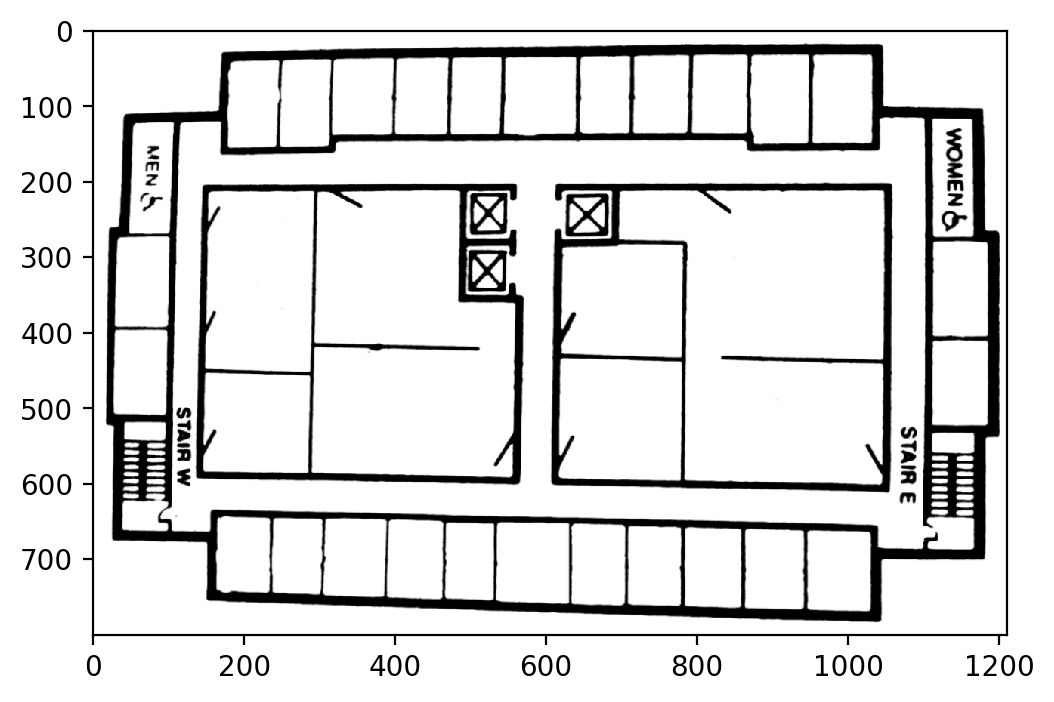

In [1]:
%matplotlib inline
from utils import polyline2array, Point, plot, polygon
import numpy as np
import math
from skimage import io
import matplotlib.pyplot as plt
from skimage.transform import estimate_transform, matrix_transform, SimilarityTransform, ProjectiveTransform, AffineTransform, warp, warp_coords
from pyproj import Proj, transform

floorplan = io.imread('floorplan_distorted.png')
plt.imshow(floorplan)

shape = floorplan.shape
width = shape[1]
height = shape[0]
print('Floorplan dimensions: width=%d height=%d' % (width, height))

ref_src = [[ 156, 670], [ 157, 747], [1035, 775], [1036, 693], [1172, 692], [1173, 531], [1190, 529], [1190, 272], [1173, 270], [1170, 109], [1039, 106],
           [1037,  24], [ 176,  33],[ 172, 111], [  47, 115], [  40, 265], [  26, 266], [  22, 514], [  34, 516], [  32, 667]]

ref_dst = [[-73.9610994, 40.8096098], [-73.9611238, 40.8095765], [-73.9606990, 40.8093975], [-73.9606732, 40.8094328], [-73.9606175, 40.8094093],
  [-73.9605793, 40.8094615], [-73.9605674, 40.8094564], [-73.9604984, 40.8095510], [-73.9605103, 40.8095560], [-73.9604712, 40.8096096],
  [-73.9605286, 40.8096338], [-73.9605026, 40.8096694], [-73.9609257, 40.8098477], [-73.9609516, 40.8098123], [-73.9610097, 40.8098368],
  [-73.9610486, 40.8097836], [-73.9610606, 40.8097887], [-73.9611311, 40.8096921], [-73.9611197, 40.8096873], [-73.9611582, 40.8096346]]

[-73.96121197  40.80989397]
[-73.96042186  40.80936188]


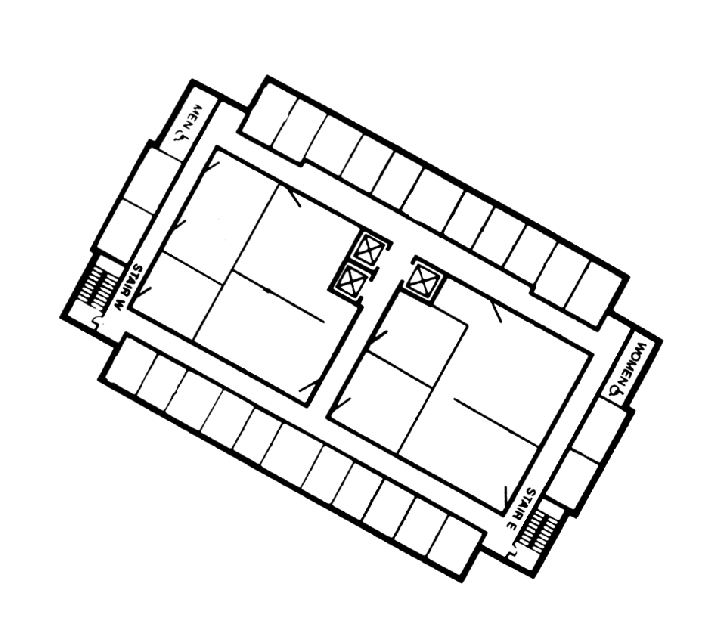

In [2]:
p4326 = Proj('epsg:4326')
p3857 = Proj('epsg:3857')
ref_dst_3857 = [[*transform(p4326, p3857, c[1], c[0])] for c in ref_dst]

tf = estimate_transform('projective', np.array(ref_src), np.array(ref_dst_3857))

corners = np.array([[0, 0], [width-1, height-1], [width-1, 0], [0, height-1]])

corners2 = matrix_transform(corners, tf.params)
min_lon = min([c[0] for c in corners2])
min_lat = min([c[1] for c in corners2])
max_lon = max([c[0] for c in corners2])
max_lat = max([c[1] for c in corners2])

dx = max_lon - min_lon
dy = max_lat - min_lat
xscale = width / dx
yscale = height / dy
scale = xscale if xscale < yscale else yscale

shift = SimilarityTransform(translation=(-min_lon, -min_lat))
scale = SimilarityTransform(scale=scale)
flip = AffineTransform(matrix=np.array([[1,  0, 0], [0, -1, height - 1], [0,  0, 1]]))

project = flip.params @ scale.params @ shift.params

w,h = matrix_transform([max_lon, min_lat], project)[0]
w = math.ceil(w)
h = math.ceil(h)

preview = warp(floorplan, ProjectiveTransform(project @ tf.params).inverse, output_shape=(h, w))

plt.axis('off')
plt.imshow(preview)

t = ProjectiveTransform(project @ tf.params)

a = matrix_transform([0,0], t._inv_matrix)[0]
b = matrix_transform([w,h], t._inv_matrix)[0]

tf2 = estimate_transform('projective', np.array(ref_src), np.array(ref_dst))
print(matrix_transform(a, tf2.params)[0])
print(matrix_transform(b, tf2.params)[0])

{"bounds": [{"lng": -73.96121197293432, "lat": 40.80989396762037}, {"lng": -73.96042185889492, "lat": 40.809361882988554}], "url": ""}

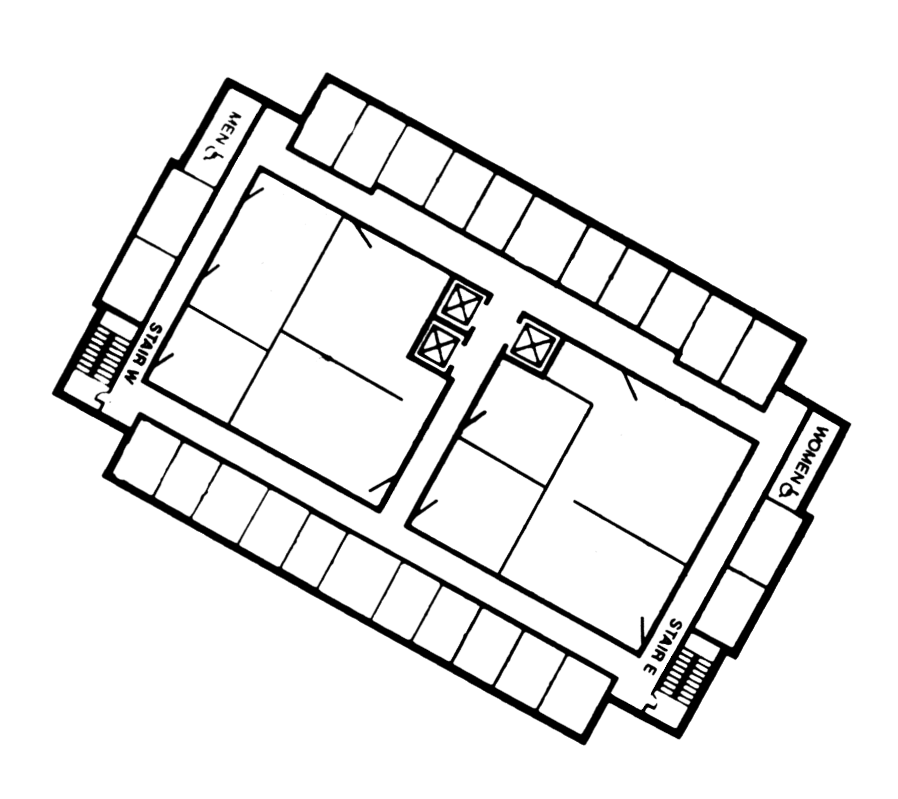

In [3]:
import json
from io import BytesIO
from base64 import b64encode
from PIL import Image

buffer = BytesIO()

bbox = matrix_transform([a, b], tf2.params)

io.imsave(buffer, preview, plugin='pil', format_str='PNG')

print(json.dumps({
    'bounds': [{
        'lng': bbox[0][0],
        'lat': bbox[0][1]
    }, {
        'lng': bbox[1][0],
        'lat': bbox[1][1]
    }],
    'url': 'data:image/png;base64,%s' % b64encode(buffer.getvalue()).decode('ascii')
}))

